# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "prompts")
from synthetic_performance_eval_script import *

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

Benchmarking Endpoint: 5e37fad2-41ee-425a-9c5f-360a04bf9a78


#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.2-11B-Vision-Instruct',
 'Meta-Llama-3.2-1B-Instruct',
 'Meta-Llama-3.3-70B-SD-Llama-3.2-1B-TP16',
 'Mistral-7B-Instruct-V0.2',
 'Qwen2.5-0.5B-Instruct']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.2-11B-Vision-Instruct',
 'Meta-Llama-3.2-1B-Instruct',
 'Meta-Llama-3.3-70B-Instruct',
 'Mistral-7B-Instruct-V0.2',
 'Qwen2.5-0.5B-Instruct']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [17]:
target_models = ['Meta-Llama-3.2-11B-Vision-Instruct',
 'Meta-Llama-3.2-1B-Instruct',
 'Meta-Llama-3.3-70B-Instruct',
 'Mistral-7B-Instruct-V0.2',
 'Qwen2.5-0.5B-Instruct']

#### Specify combinatorial inputs for benchmarking

In [18]:
input_tokens = [3900, 8000, 16000]
output_tokens = [100]
num_requests = [64]
concurrent_requests = [1, 2, 4, 8, 16, 32]

#### Automatically generate configs

In [19]:
model_configs_df = pd.DataFrame(columns=[
                "model_name",
                "input_tokens",
                "output_tokens",
                "num_requests",
                "concurrent_requests"
                ])
counter = 1
for target_model in target_models:
    for input_token in input_tokens:
        for output_token in output_tokens:
            for num_request in num_requests:
                for concurrent_request in concurrent_requests:
                    model_configs_df.loc[counter] = [
                                        target_model, 
                                        input_token,
                                        output_token,
                                        num_request,
                                        concurrent_request
                                    ]
                    counter += 1


#### Confirm model configs and delete any configs that you would rather exclude

In [20]:
drop_rows = model_configs_df[(model_configs_df["model_name"] == "Qwen2.5-72B-Instruct") &
            (model_configs_df["input_tokens"] > 3900)].index.tolist()
model_configs_df.drop(drop_rows, inplace=True)
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,Meta-Llama-3.2-11B-Vision-Instruct,3900,100,64,1
2,Meta-Llama-3.2-11B-Vision-Instruct,3900,100,64,2
3,Meta-Llama-3.2-11B-Vision-Instruct,3900,100,64,4
4,Meta-Llama-3.2-11B-Vision-Instruct,3900,100,64,8
5,Meta-Llama-3.2-11B-Vision-Instruct,3900,100,64,16
...,...,...,...,...,...
86,Qwen2.5-0.5B-Instruct,16000,100,64,2
87,Qwen2.5-0.5B-Instruct,16000,100,64,4
88,Qwen2.5-0.5B-Instruct,16000,100,64,8
89,Qwen2.5-0.5B-Instruct,16000,100,64,16


## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [21]:
run_name = "coe-dso-eval-3_test_20250606_1"

#### Configure saving options
Saving makes it easy to re-run the model configs by skipping all the above sections

In [22]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"
config = {
    'model_configs_path': f'{output_path}model_configs_{run_name}.csv', # leave this as is
    'llm_api': 'sambastudio', # leave this as is
    'output_files_dir': f'{output_path}logs/output_files', # each run saved here
    'consolidated_results_dir': f'{output_path}consolidated_results', # consolidated xlsx saved here
    'timeout': 3600,
    'time_delay': 0, # between batches of concurrent requests
}

#### Save configs

In [23]:
with open(f"{output_path}config_{run_name}.yaml", "w") as f:
    yaml.dump(config, f, default_flow_style=False)
model_configs_df.to_csv(config["model_configs_path"], index=False)

#### Run configs

In [24]:
run_benchmarking(config=config, benchmarking_dir=benchmarking_dir, run_name=run_name)

2025-06-06 11:01:19,516 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


2025-06-06 11:01:34,715 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:34,716 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:34,716 [INFO] Time delay: 0 seconds
2025-06-06 11:01:34,717 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


2025-06-06 11:01:41,047 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:41,048 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:41,049 [INFO] Time delay: 0 seconds
2025-06-06 11:01:41,049 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:06<00:00, 10.10it/s]


2025-06-06 11:01:44,832 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:44,833 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:44,833 [INFO] Time delay: 0 seconds
2025-06-06 11:01:44,834 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


2025-06-06 11:01:47,790 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:47,790 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:47,791 [INFO] Time delay: 0 seconds
2025-06-06 11:01:47,792 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 20.88it/s]


2025-06-06 11:01:50,817 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:50,818 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:50,818 [INFO] Time delay: 0 seconds
2025-06-06 11:01:50,820 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:02<00:00, 22.05it/s]


2025-06-06 11:01:53,670 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:01:53,671 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:01:53,671 [INFO] Time delay: 0 seconds
2025-06-06 11:01:53,672 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:02<00:00, 22.27it/s]


2025-06-06 11:02:09,859 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:09,860 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:09,860 [INFO] Time delay: 0 seconds
2025-06-06 11:02:09,861 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:16<00:00,  3.96it/s]


2025-06-06 11:02:18,455 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:18,456 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:18,456 [INFO] Time delay: 0 seconds
2025-06-06 11:02:18,457 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:08<00:00,  7.45it/s]


2025-06-06 11:02:24,281 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:24,282 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:24,284 [INFO] Time delay: 0 seconds
2025-06-06 11:02:24,286 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:05<00:00, 10.98it/s]


2025-06-06 11:02:29,456 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:29,457 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:29,458 [INFO] Time delay: 0 seconds
2025-06-06 11:02:29,459 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:05<00:00, 12.41it/s]


2025-06-06 11:02:34,546 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:34,547 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:34,547 [INFO] Time delay: 0 seconds
2025-06-06 11:02:34,548 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:05<00:00, 12.50it/s]


2025-06-06 11:02:39,605 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:02:39,605 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:02:39,606 [INFO] Time delay: 0 seconds
2025-06-06 11:02:39,607 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:05<00:00, 12.75it/s]


2025-06-06 11:03:04,219 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:04,221 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:04,222 [INFO] Time delay: 0 seconds
2025-06-06 11:03:04,223 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]


2025-06-06 11:03:17,015 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:17,017 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:17,017 [INFO] Time delay: 0 seconds
2025-06-06 11:03:17,019 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:12<00:00,  5.00it/s]


2025-06-06 11:03:27,146 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:27,147 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:27,148 [INFO] Time delay: 0 seconds
2025-06-06 11:03:27,148 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:10<00:00,  6.34it/s]


2025-06-06 11:03:36,922 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:36,923 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:36,923 [INFO] Time delay: 0 seconds
2025-06-06 11:03:36,925 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:09<00:00,  6.51it/s]


2025-06-06 11:03:46,611 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:46,611 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:46,612 [INFO] Time delay: 0 seconds
2025-06-06 11:03:46,613 [INFO] Running model_name Meta-Llama-3.2-11B-Vision-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:09<00:00,  6.54it/s]


2025-06-06 11:03:56,237 [ERROR] Error while running model_name Meta-Llama-3.2-11B-Vision-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:03:56,237 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Error: 'choices' at streamed event: {"error":{"code":null,"message":"unexpected_error","param":null,"type":"unexpected_error"}}
2025-06-06 11:03:56,238 [INFO] Time delay: 0 seconds
2025-06-06 11:03:56,239 [INFO] Running model_name Meta-Llama-3.2-1B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:09<00:00,  6.74it/s]


2025-06-06 11:04:18,155 [INFO] Tasks Executed!
2025-06-06 11:04:18,156 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:04:18,184 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:04:18,187 [INFO]     p5 = 0.1864
2025-06-06 11:04:18,187 [INFO]     p25 = 0.2094
2025-06-06 11:04:18,188 [INFO]     p50 = 0.2296
2025-06-06 11:04:18,188 [INFO]     p75 = 0.2627
2025-06-06 11:04:18,188 [INFO]     p90 = 0.2961
2025-06-06 11:04:18,188 [INFO]     p95 = 0.3307
2025-06-06 11:04:18,189 [INFO]     p99 = 1.1678
2025-06-06 11:04:18,190 [INFO]     mean = 0.2742
2025-06-06 11:04:18,190 [INFO]     min = 0.1812
2025-06-06 11:04:18,190 [INFO]     max = 2.4968
2025-06-06 11:04:18,190 [INFO]     stddev = 0.2856
2025-06-06 11:04:18,191 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:04:18,192 [INFO]     p5 = 0.2396
2025-06-06 11:04:18,193 [INFO]     p25 = 0.2613
202

Running Requests: 100%|██████████| 64/64 [00:22<00:00,  2.89it/s]


2025-06-06 11:04:27,681 [INFO] Tasks Executed!
2025-06-06 11:04:27,682 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:04:27,693 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:04:27,695 [INFO]     p5 = 0.1866
2025-06-06 11:04:27,695 [INFO]     p25 = 0.1971
2025-06-06 11:04:27,696 [INFO]     p50 = 0.207
2025-06-06 11:04:27,696 [INFO]     p75 = 0.2162
2025-06-06 11:04:27,696 [INFO]     p90 = 0.2337
2025-06-06 11:04:27,697 [INFO]     p95 = 0.248
2025-06-06 11:04:27,697 [INFO]     p99 = 0.2974
2025-06-06 11:04:27,698 [INFO]     mean = 0.2107
2025-06-06 11:04:27,698 [INFO]     min = 0.1817
2025-06-06 11:04:27,699 [INFO]     max = 0.313
2025-06-06 11:04:27,699 [INFO]     stddev = 0.0224
2025-06-06 11:04:27,700 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:04:27,702 [INFO]     p5 = 0.241
2025-06-06 11:04:27,702 [INFO]     p25 = 0.2518
2025-06

Running Requests: 100%|██████████| 64/64 [00:09<00:00,  6.82it/s]


2025-06-06 11:04:38,502 [INFO] Tasks Executed!
2025-06-06 11:04:38,502 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:04:38,514 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:04:38,517 [INFO]     p5 = 0.2025
2025-06-06 11:04:38,517 [INFO]     p25 = 0.2349
2025-06-06 11:04:38,518 [INFO]     p50 = 0.3148
2025-06-06 11:04:38,518 [INFO]     p75 = 0.3433
2025-06-06 11:04:38,518 [INFO]     p90 = 2.3975
2025-06-06 11:04:38,519 [INFO]     p95 = 2.4448
2025-06-06 11:04:38,519 [INFO]     p99 = 2.5357
2025-06-06 11:04:38,520 [INFO]     mean = 0.5566
2025-06-06 11:04:38,520 [INFO]     min = 0.1774
2025-06-06 11:04:38,521 [INFO]     max = 2.5621
2025-06-06 11:04:38,521 [INFO]     stddev = 0.7278
2025-06-06 11:04:38,521 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:04:38,523 [INFO]     p5 = 0.2576
2025-06-06 11:04:38,523 [INFO]     p25 = 0.2969
202

Running Requests: 100%|██████████| 64/64 [00:10<00:00,  5.90it/s]


2025-06-06 11:04:45,502 [INFO] Tasks Executed!
2025-06-06 11:04:45,503 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:04:45,515 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:04:45,517 [INFO]     p5 = 0.3258
2025-06-06 11:04:45,517 [INFO]     p25 = 0.337
2025-06-06 11:04:45,518 [INFO]     p50 = 0.3467
2025-06-06 11:04:45,518 [INFO]     p75 = 0.5269
2025-06-06 11:04:45,519 [INFO]     p90 = 2.7229
2025-06-06 11:04:45,519 [INFO]     p95 = 2.9174
2025-06-06 11:04:45,520 [INFO]     p99 = 2.9538
2025-06-06 11:04:45,521 [INFO]     mean = 0.6797
2025-06-06 11:04:45,521 [INFO]     min = 0.188
2025-06-06 11:04:45,522 [INFO]     max = 2.9539
2025-06-06 11:04:45,522 [INFO]     stddev = 0.8268
2025-06-06 11:04:45,522 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:04:45,524 [INFO]     p5 = 0.3931
2025-06-06 11:04:45,525 [INFO]     p25 = 0.4047
2025-

Running Requests: 100%|██████████| 64/64 [00:07<00:00,  9.06it/s]


2025-06-06 11:04:52,026 [INFO] Tasks Executed!
2025-06-06 11:04:52,026 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:04:52,038 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:04:52,040 [INFO]     p5 = 0.3915
2025-06-06 11:04:52,040 [INFO]     p25 = 0.6035
2025-06-06 11:04:52,041 [INFO]     p50 = 0.7145
2025-06-06 11:04:52,041 [INFO]     p75 = 1.4931
2025-06-06 11:04:52,042 [INFO]     p90 = 2.8899
2025-06-06 11:04:52,042 [INFO]     p95 = 3.3404
2025-06-06 11:04:52,043 [INFO]     p99 = 3.3414
2025-06-06 11:04:52,043 [INFO]     mean = 1.2459
2025-06-06 11:04:52,044 [INFO]     min = 0.2051
2025-06-06 11:04:52,044 [INFO]     max = 3.3418
2025-06-06 11:04:52,044 [INFO]     stddev = 1.0533
2025-06-06 11:04:52,045 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:04:52,046 [INFO]     p5 = 0.4591
2025-06-06 11:04:52,047 [INFO]     p25 = 0.6755
202

Running Requests: 100%|██████████| 64/64 [00:06<00:00, 10.00it/s]


2025-06-06 11:05:01,502 [INFO] Tasks Executed!
2025-06-06 11:05:01,503 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:05:01,512 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:05:01,513 [INFO]     p5 = 0.419
2025-06-06 11:05:01,514 [INFO]     p25 = 1.1539
2025-06-06 11:05:01,514 [INFO]     p50 = 3.9928
2025-06-06 11:05:01,514 [INFO]     p75 = 6.666
2025-06-06 11:05:01,514 [INFO]     p90 = 7.1024
2025-06-06 11:05:01,515 [INFO]     p95 = 7.1116
2025-06-06 11:05:01,515 [INFO]     p99 = 7.4356
2025-06-06 11:05:01,515 [INFO]     mean = 3.8822
2025-06-06 11:05:01,516 [INFO]     min = 0.2273
2025-06-06 11:05:01,516 [INFO]     max = 7.437
2025-06-06 11:05:01,516 [INFO]     stddev = 2.3657
2025-06-06 11:05:01,516 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:05:01,518 [INFO]     p5 = 0.4882
2025-06-06 11:05:01,518 [INFO]     p25 = 1.2437
2025-0

Running Requests: 100%|██████████| 64/64 [00:09<00:00,  6.74it/s]


2025-06-06 11:05:30,399 [INFO] Tasks Executed!
2025-06-06 11:05:30,401 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:05:30,418 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:05:30,421 [INFO]     p5 = 0.2733
2025-06-06 11:05:30,422 [INFO]     p25 = 0.2983
2025-06-06 11:05:30,422 [INFO]     p50 = 0.3501
2025-06-06 11:05:30,423 [INFO]     p75 = 0.4178
2025-06-06 11:05:30,423 [INFO]     p90 = 0.4599
2025-06-06 11:05:30,423 [INFO]     p95 = 0.4825
2025-06-06 11:05:30,424 [INFO]     p99 = 0.9036
2025-06-06 11:05:30,424 [INFO]     mean = 0.3777
2025-06-06 11:05:30,425 [INFO]     min = 0.2581
2025-06-06 11:05:30,425 [INFO]     max = 1.598
2025-06-06 11:05:30,425 [INFO]     stddev = 0.1687
2025-06-06 11:05:30,426 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:05:30,427 [INFO]     p5 = 0.3297
2025-06-06 11:05:30,428 [INFO]     p25 = 0.3562
2025

Running Requests: 100%|██████████| 64/64 [00:29<00:00,  2.20it/s]


2025-06-06 11:05:42,878 [INFO] Tasks Executed!
2025-06-06 11:05:42,879 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:05:42,892 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:05:42,894 [INFO]     p5 = 0.2702
2025-06-06 11:05:42,895 [INFO]     p25 = 0.2765
2025-06-06 11:05:42,895 [INFO]     p50 = 0.2906
2025-06-06 11:05:42,895 [INFO]     p75 = 0.3097
2025-06-06 11:05:42,896 [INFO]     p90 = 0.3315
2025-06-06 11:05:42,896 [INFO]     p95 = 0.3572
2025-06-06 11:05:42,897 [INFO]     p99 = 0.3977
2025-06-06 11:05:42,898 [INFO]     mean = 0.2986
2025-06-06 11:05:42,898 [INFO]     min = 0.2678
2025-06-06 11:05:42,898 [INFO]     max = 0.4255
2025-06-06 11:05:42,899 [INFO]     stddev = 0.0306
2025-06-06 11:05:42,899 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:05:42,901 [INFO]     p5 = 0.3279
2025-06-06 11:05:42,901 [INFO]     p25 = 0.3344
202

Running Requests: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]


2025-06-06 11:05:55,090 [INFO] Tasks Executed!
2025-06-06 11:05:55,090 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:05:55,102 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:05:55,104 [INFO]     p5 = 0.4444
2025-06-06 11:05:55,104 [INFO]     p25 = 0.4518
2025-06-06 11:05:55,105 [INFO]     p50 = 0.455
2025-06-06 11:05:55,105 [INFO]     p75 = 0.458
2025-06-06 11:05:55,105 [INFO]     p90 = 1.6593
2025-06-06 11:05:55,106 [INFO]     p95 = 1.9254
2025-06-06 11:05:55,106 [INFO]     p99 = 2.0135
2025-06-06 11:05:55,107 [INFO]     mean = 0.6265
2025-06-06 11:05:55,108 [INFO]     min = 0.2627
2025-06-06 11:05:55,108 [INFO]     max = 2.014
2025-06-06 11:05:55,108 [INFO]     stddev = 0.4762
2025-06-06 11:05:55,109 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:05:55,110 [INFO]     p5 = 0.5091
2025-06-06 11:05:55,111 [INFO]     p25 = 0.5156
2025-0

Running Requests: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s]


2025-06-06 11:06:03,139 [INFO] Tasks Executed!
2025-06-06 11:06:03,139 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:06:03,151 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:06:03,153 [INFO]     p5 = 0.7057
2025-06-06 11:06:03,153 [INFO]     p25 = 0.7662
2025-06-06 11:06:03,154 [INFO]     p50 = 0.7834
2025-06-06 11:06:03,154 [INFO]     p75 = 0.807
2025-06-06 11:06:03,154 [INFO]     p90 = 0.876
2025-06-06 11:06:03,155 [INFO]     p95 = 0.8915
2025-06-06 11:06:03,155 [INFO]     p99 = 1.1301
2025-06-06 11:06:03,157 [INFO]     mean = 0.7942
2025-06-06 11:06:03,157 [INFO]     min = 0.2861
2025-06-06 11:06:03,157 [INFO]     max = 1.1307
2025-06-06 11:06:03,158 [INFO]     stddev = 0.1063
2025-06-06 11:06:03,158 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:06:03,160 [INFO]     p5 = 0.7718
2025-06-06 11:06:03,160 [INFO]     p25 = 0.8351
2025-

Running Requests: 100%|██████████| 64/64 [00:07<00:00,  8.01it/s]


2025-06-06 11:06:15,081 [INFO] Tasks Executed!
2025-06-06 11:06:15,082 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:06:15,094 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:06:15,096 [INFO]     p5 = 0.7841
2025-06-06 11:06:15,096 [INFO]     p25 = 1.979
2025-06-06 11:06:15,097 [INFO]     p50 = 2.019
2025-06-06 11:06:15,097 [INFO]     p75 = 3.2558
2025-06-06 11:06:15,097 [INFO]     p90 = 3.2683
2025-06-06 11:06:15,098 [INFO]     p95 = 4.3803
2025-06-06 11:06:15,099 [INFO]     p99 = 4.9807
2025-06-06 11:06:15,099 [INFO]     mean = 2.5228
2025-06-06 11:06:15,100 [INFO]     min = 0.3567
2025-06-06 11:06:15,100 [INFO]     max = 5.2419
2025-06-06 11:06:15,100 [INFO]     stddev = 1.0089
2025-06-06 11:06:15,101 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:06:15,102 [INFO]     p5 = 0.8493
2025-06-06 11:06:15,102 [INFO]     p25 = 2.1122
2025-

Running Requests: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s]


2025-06-06 11:06:23,201 [INFO] Tasks Executed!
2025-06-06 11:06:23,202 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:06:23,211 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:06:23,213 [INFO]     p5 = 1.0925
2025-06-06 11:06:23,213 [INFO]     p25 = 2.6131
2025-06-06 11:06:23,213 [INFO]     p50 = 2.6976
2025-06-06 11:06:23,214 [INFO]     p75 = 2.7312
2025-06-06 11:06:23,214 [INFO]     p90 = 3.9305
2025-06-06 11:06:23,214 [INFO]     p95 = 3.9353
2025-06-06 11:06:23,215 [INFO]     p99 = 3.9379
2025-06-06 11:06:23,215 [INFO]     mean = 2.7267
2025-06-06 11:06:23,215 [INFO]     min = 0.4061
2025-06-06 11:06:23,216 [INFO]     max = 3.9395
2025-06-06 11:06:23,216 [INFO]     stddev = 0.7352
2025-06-06 11:06:23,216 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:06:23,218 [INFO]     p5 = 1.1843
2025-06-06 11:06:23,219 [INFO]     p25 = 2.65
2025-

Running Requests: 100%|██████████| 64/64 [00:07<00:00,  8.21it/s]


2025-06-06 11:07:06,552 [INFO] Tasks Executed!
2025-06-06 11:07:06,553 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:07:06,570 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:07:06,573 [INFO]     p5 = 0.5006
2025-06-06 11:07:06,573 [INFO]     p25 = 0.5131
2025-06-06 11:07:06,574 [INFO]     p50 = 0.554
2025-06-06 11:07:06,574 [INFO]     p75 = 0.5867
2025-06-06 11:07:06,574 [INFO]     p90 = 0.6663
2025-06-06 11:07:06,575 [INFO]     p95 = 0.6947
2025-06-06 11:07:06,575 [INFO]     p99 = 1.428
2025-06-06 11:07:06,576 [INFO]     mean = 0.5944
2025-06-06 11:07:06,576 [INFO]     min = 0.4936
2025-06-06 11:07:06,576 [INFO]     max = 2.6284
2025-06-06 11:07:06,577 [INFO]     stddev = 0.2645
2025-06-06 11:07:06,577 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:07:06,578 [INFO]     p5 = 0.5746
2025-06-06 11:07:06,579 [INFO]     p25 = 0.5891
2025-

Running Requests: 100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


2025-06-06 11:07:32,987 [INFO] Tasks Executed!
2025-06-06 11:07:32,988 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:07:33,002 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:07:33,005 [INFO]     p5 = 0.684
2025-06-06 11:07:33,005 [INFO]     p25 = 0.6924
2025-06-06 11:07:33,005 [INFO]     p50 = 0.7023
2025-06-06 11:07:33,006 [INFO]     p75 = 0.7154
2025-06-06 11:07:33,006 [INFO]     p90 = 0.7269
2025-06-06 11:07:33,006 [INFO]     p95 = 0.7333
2025-06-06 11:07:33,007 [INFO]     p99 = 0.7982
2025-06-06 11:07:33,007 [INFO]     mean = 0.7043
2025-06-06 11:07:33,008 [INFO]     min = 0.5101
2025-06-06 11:07:33,008 [INFO]     max = 0.8826
2025-06-06 11:07:33,008 [INFO]     stddev = 0.0366
2025-06-06 11:07:33,009 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:07:33,010 [INFO]     p5 = 0.7606
2025-06-06 11:07:33,011 [INFO]     p25 = 0.7695
2025

Running Requests: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]


2025-06-06 11:08:03,901 [INFO] Tasks Executed!
2025-06-06 11:08:03,902 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:08:03,912 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:08:03,914 [INFO]     p5 = 1.6155
2025-06-06 11:08:03,914 [INFO]     p25 = 1.6262
2025-06-06 11:08:03,915 [INFO]     p50 = 1.6413
2025-06-06 11:08:03,915 [INFO]     p75 = 1.6671
2025-06-06 11:08:03,915 [INFO]     p90 = 1.7255
2025-06-06 11:08:03,916 [INFO]     p95 = 3.5405
2025-06-06 11:08:03,916 [INFO]     p99 = 4.0207
2025-06-06 11:08:03,917 [INFO]     mean = 1.7769
2025-06-06 11:08:03,917 [INFO]     min = 0.4949
2025-06-06 11:08:03,917 [INFO]     max = 4.021
2025-06-06 11:08:03,918 [INFO]     stddev = 0.5923
2025-06-06 11:08:03,918 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:08:03,919 [INFO]     p5 = 1.7013
2025-06-06 11:08:03,919 [INFO]     p25 = 1.7136
2025

Running Requests: 100%|██████████| 64/64 [00:30<00:00,  2.07it/s]


2025-06-06 11:08:33,208 [INFO] Tasks Executed!
2025-06-06 11:08:33,209 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:08:33,221 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:08:33,223 [INFO]     p5 = 2.7256
2025-06-06 11:08:33,223 [INFO]     p25 = 2.7393
2025-06-06 11:08:33,224 [INFO]     p50 = 2.7625
2025-06-06 11:08:33,224 [INFO]     p75 = 2.8182
2025-06-06 11:08:33,225 [INFO]     p90 = 6.0813
2025-06-06 11:08:33,225 [INFO]     p95 = 6.0855
2025-06-06 11:08:33,225 [INFO]     p99 = 8.1831
2025-06-06 11:08:33,226 [INFO]     mean = 3.3746
2025-06-06 11:08:33,226 [INFO]     min = 0.5499
2025-06-06 11:08:33,227 [INFO]     max = 8.5716
2025-06-06 11:08:33,227 [INFO]     stddev = 1.4242
2025-06-06 11:08:33,227 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:08:33,228 [INFO]     p5 = 2.8378
2025-06-06 11:08:33,229 [INFO]     p25 = 2.852
2025

Running Requests: 100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


2025-06-06 11:08:56,295 [INFO] Tasks Executed!
2025-06-06 11:08:56,296 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:08:56,305 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:08:56,306 [INFO]     p5 = 2.8238
2025-06-06 11:08:56,306 [INFO]     p25 = 4.6878
2025-06-06 11:08:56,307 [INFO]     p50 = 4.833
2025-06-06 11:08:56,307 [INFO]     p75 = 5.4204
2025-06-06 11:08:56,308 [INFO]     p90 = 7.8203
2025-06-06 11:08:56,308 [INFO]     p95 = 7.8267
2025-06-06 11:08:56,308 [INFO]     p99 = 7.8295
2025-06-06 11:08:56,309 [INFO]     mean = 5.138
2025-06-06 11:08:56,309 [INFO]     min = 0.6452
2025-06-06 11:08:56,310 [INFO]     max = 7.8325
2025-06-06 11:08:56,310 [INFO]     stddev = 1.5558
2025-06-06 11:08:56,310 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:08:56,311 [INFO]     p5 = 2.9437
2025-06-06 11:08:56,312 [INFO]     p25 = 4.8006
2025-

Running Requests: 100%|██████████| 64/64 [00:23<00:00,  2.77it/s]


2025-06-06 11:09:16,235 [INFO] Tasks Executed!
2025-06-06 11:09:16,235 [INFO] Benchmarking results obtained for model Meta-Llama-3.2-1B-Instruct queried with the sambastudio API.
2025-06-06 11:09:16,245 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:09:16,246 [INFO]     p5 = 2.9242
2025-06-06 11:09:16,247 [INFO]     p25 = 5.7286
2025-06-06 11:09:16,247 [INFO]     p50 = 8.1607
2025-06-06 11:09:16,247 [INFO]     p75 = 8.4789
2025-06-06 11:09:16,248 [INFO]     p90 = 10.9386
2025-06-06 11:09:16,248 [INFO]     p95 = 11.1724
2025-06-06 11:09:16,248 [INFO]     p99 = 11.2163
2025-06-06 11:09:16,249 [INFO]     mean = 7.5811
2025-06-06 11:09:16,249 [INFO]     min = 0.7344
2025-06-06 11:09:16,250 [INFO]     max = 11.2177
2025-06-06 11:09:16,250 [INFO]     stddev = 2.425
2025-06-06 11:09:16,250 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:09:16,252 [INFO]     p5 = 3.0342
2025-06-06 11:09:16,252 [INFO]     p25 = 5.8425


Running Requests: 100%|██████████| 64/64 [00:19<00:00,  3.20it/s]


2025-06-06 11:10:11,832 [INFO] Tasks Executed!
2025-06-06 11:10:11,833 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:10:11,845 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:10:11,847 [INFO]     p5 = 0.5461
2025-06-06 11:10:11,848 [INFO]     p25 = 0.569
2025-06-06 11:10:11,848 [INFO]     p50 = 0.5921
2025-06-06 11:10:11,849 [INFO]     p75 = 0.6245
2025-06-06 11:10:11,849 [INFO]     p90 = 0.7303
2025-06-06 11:10:11,849 [INFO]     p95 = 0.7624
2025-06-06 11:10:11,850 [INFO]     p99 = 1.8865
2025-06-06 11:10:11,850 [INFO]     mean = 0.6589
2025-06-06 11:10:11,851 [INFO]     min = 0.5407
2025-06-06 11:10:11,851 [INFO]     max = 3.6179
2025-06-06 11:10:11,851 [INFO]     stddev = 0.3817
2025-06-06 11:10:11,852 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:10:11,853 [INFO]     p5 = 0.7538
2025-06-06 11:10:11,854 [INFO]     p25 = 0.773
2025

Running Requests: 100%|██████████| 64/64 [00:55<00:00,  1.14it/s]


2025-06-06 11:10:53,063 [INFO] Tasks Executed!
2025-06-06 11:10:53,064 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:10:53,085 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:10:53,087 [INFO]     p5 = 1.0259
2025-06-06 11:10:53,087 [INFO]     p25 = 1.0308
2025-06-06 11:10:53,088 [INFO]     p50 = 1.0406
2025-06-06 11:10:53,088 [INFO]     p75 = 1.1043
2025-06-06 11:10:53,089 [INFO]     p90 = 1.1336
2025-06-06 11:10:53,089 [INFO]     p95 = 1.1391
2025-06-06 11:10:53,089 [INFO]     p99 = 1.1461
2025-06-06 11:10:53,090 [INFO]     mean = 1.0561
2025-06-06 11:10:53,091 [INFO]     min = 0.5296
2025-06-06 11:10:53,091 [INFO]     max = 1.1471
2025-06-06 11:10:53,091 [INFO]     stddev = 0.0787
2025-06-06 11:10:53,092 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:10:53,093 [INFO]     p5 = 1.2348
2025-06-06 11:10:53,093 [INFO]     p25 = 1.2393
20

Running Requests: 100%|██████████| 64/64 [00:40<00:00,  1.56it/s]


2025-06-06 11:11:31,054 [INFO] Tasks Executed!
2025-06-06 11:11:31,054 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:11:31,065 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:11:31,067 [INFO]     p5 = 1.8787
2025-06-06 11:11:31,068 [INFO]     p25 = 1.8902
2025-06-06 11:11:31,068 [INFO]     p50 = 1.9168
2025-06-06 11:11:31,068 [INFO]     p75 = 1.9576
2025-06-06 11:11:31,068 [INFO]     p90 = 1.9798
2025-06-06 11:11:31,069 [INFO]     p95 = 4.3075
2025-06-06 11:11:31,069 [INFO]     p99 = 4.7724
2025-06-06 11:11:31,070 [INFO]     mean = 2.0761
2025-06-06 11:11:31,070 [INFO]     min = 0.5289
2025-06-06 11:11:31,070 [INFO]     max = 4.7727
2025-06-06 11:11:31,071 [INFO]     stddev = 0.7202
2025-06-06 11:11:31,071 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:11:31,072 [INFO]     p5 = 2.1212
2025-06-06 11:11:31,073 [INFO]     p25 = 2.1289
20

Running Requests: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]


2025-06-06 11:12:02,269 [INFO] Tasks Executed!
2025-06-06 11:12:02,269 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:12:02,281 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:12:02,283 [INFO]     p5 = 3.0984
2025-06-06 11:12:02,283 [INFO]     p25 = 3.1083
2025-06-06 11:12:02,283 [INFO]     p50 = 3.1168
2025-06-06 11:12:02,284 [INFO]     p75 = 3.1807
2025-06-06 11:12:02,284 [INFO]     p90 = 6.2872
2025-06-06 11:12:02,284 [INFO]     p95 = 6.2984
2025-06-06 11:12:02,285 [INFO]     p99 = 6.3196
2025-06-06 11:12:02,285 [INFO]     mean = 3.4863
2025-06-06 11:12:02,286 [INFO]     min = 0.5641
2025-06-06 11:12:02,286 [INFO]     max = 6.3475
2025-06-06 11:12:02,286 [INFO]     stddev = 1.1199
2025-06-06 11:12:02,286 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:12:02,288 [INFO]     p5 = 3.3722
2025-06-06 11:12:02,288 [INFO]     p25 = 3.3794
20

Running Requests: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s]


2025-06-06 11:12:34,963 [INFO] Tasks Executed!
2025-06-06 11:12:34,963 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:12:34,976 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:12:34,977 [INFO]     p5 = 5.6204
2025-06-06 11:12:34,978 [INFO]     p25 = 5.6327
2025-06-06 11:12:34,978 [INFO]     p50 = 5.6435
2025-06-06 11:12:34,978 [INFO]     p75 = 6.5578
2025-06-06 11:12:34,978 [INFO]     p90 = 13.4555
2025-06-06 11:12:34,978 [INFO]     p95 = 13.4612
2025-06-06 11:12:34,979 [INFO]     p99 = 13.4628
2025-06-06 11:12:34,979 [INFO]     mean = 7.4509
2025-06-06 11:12:34,979 [INFO]     min = 5.414
2025-06-06 11:12:34,980 [INFO]     max = 13.4633
2025-06-06 11:12:34,980 [INFO]     stddev = 3.2514
2025-06-06 11:12:34,980 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:12:34,981 [INFO]     p5 = 5.955
2025-06-06 11:12:34,981 [INFO]     p25 = 5.9704


Running Requests: 100%|██████████| 64/64 [00:32<00:00,  1.96it/s]


2025-06-06 11:13:10,494 [INFO] Tasks Executed!
2025-06-06 11:13:10,494 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:13:10,505 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:13:10,506 [INFO]     p5 = 13.6141
2025-06-06 11:13:10,506 [INFO]     p25 = 13.6234
2025-06-06 11:13:10,507 [INFO]     p50 = 14.9395
2025-06-06 11:13:10,507 [INFO]     p75 = 15.0843
2025-06-06 11:13:10,507 [INFO]     p90 = 18.9316
2025-06-06 11:13:10,508 [INFO]     p95 = 18.9422
2025-06-06 11:13:10,508 [INFO]     p99 = 18.9462
2025-06-06 11:13:10,508 [INFO]     mean = 14.8961
2025-06-06 11:13:10,509 [INFO]     min = 0.5619
2025-06-06 11:13:10,509 [INFO]     max = 18.9462
2025-06-06 11:13:10,509 [INFO]     stddev = 2.5174
2025-06-06 11:13:10,509 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:13:10,510 [INFO]     p5 = 14.1539
2025-06-06 11:13:10,511 [INFO]     p25 =

Running Requests: 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]


2025-06-06 11:14:43,678 [INFO] Tasks Executed!
2025-06-06 11:14:43,680 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:14:43,706 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:14:43,708 [INFO]     p5 = 1.1095
2025-06-06 11:14:43,708 [INFO]     p25 = 1.1331
2025-06-06 11:14:43,709 [INFO]     p50 = 1.1592
2025-06-06 11:14:43,709 [INFO]     p75 = 1.1873
2025-06-06 11:14:43,709 [INFO]     p90 = 1.2225
2025-06-06 11:14:43,710 [INFO]     p95 = 1.2347
2025-06-06 11:14:43,710 [INFO]     p99 = 1.9953
2025-06-06 11:14:43,711 [INFO]     mean = 1.1936
2025-06-06 11:14:43,711 [INFO]     min = 1.0953
2025-06-06 11:14:43,712 [INFO]     max = 3.2317
2025-06-06 11:14:43,712 [INFO]     stddev = 0.2616
2025-06-06 11:14:43,712 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:14:43,714 [INFO]     p5 = 1.3654
2025-06-06 11:14:43,714 [INFO]     p25 = 1.3878
20

Running Requests: 100%|██████████| 64/64 [01:33<00:00,  1.46s/it]


2025-06-06 11:16:02,449 [INFO] Tasks Executed!
2025-06-06 11:16:02,451 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:16:02,476 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:16:02,481 [INFO]     p5 = 2.1412
2025-06-06 11:16:02,482 [INFO]     p25 = 2.1464
2025-06-06 11:16:02,486 [INFO]     p50 = 2.162
2025-06-06 11:16:02,487 [INFO]     p75 = 2.2119
2025-06-06 11:16:02,487 [INFO]     p90 = 2.2393
2025-06-06 11:16:02,487 [INFO]     p95 = 2.2443
2025-06-06 11:16:02,488 [INFO]     p99 = 2.2839
2025-06-06 11:16:02,488 [INFO]     mean = 2.1626
2025-06-06 11:16:02,488 [INFO]     min = 1.1169
2025-06-06 11:16:02,489 [INFO]     max = 2.3316
2025-06-06 11:16:02,489 [INFO]     stddev = 0.1387
2025-06-06 11:16:02,489 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:16:02,490 [INFO]     p5 = 2.3979
2025-06-06 11:16:02,490 [INFO]     p25 = 2.4033
202

Running Requests: 100%|██████████| 64/64 [01:18<00:00,  1.22s/it]


2025-06-06 11:17:29,651 [INFO] Tasks Executed!
2025-06-06 11:17:29,660 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:17:29,762 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:17:29,770 [INFO]     p5 = 4.944
2025-06-06 11:17:29,772 [INFO]     p25 = 4.9605
2025-06-06 11:17:29,774 [INFO]     p50 = 4.9945
2025-06-06 11:17:29,774 [INFO]     p75 = 5.0391
2025-06-06 11:17:29,775 [INFO]     p90 = 5.0774
2025-06-06 11:17:29,776 [INFO]     p95 = 6.6211
2025-06-06 11:17:29,778 [INFO]     p99 = 7.0551
2025-06-06 11:17:29,780 [INFO]     mean = 5.0606
2025-06-06 11:17:29,781 [INFO]     min = 1.1156
2025-06-06 11:17:29,783 [INFO]     max = 7.0554
2025-06-06 11:17:29,784 [INFO]     stddev = 0.7037
2025-06-06 11:17:29,785 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:17:29,789 [INFO]     p5 = 5.2321
2025-06-06 11:17:29,791 [INFO]     p25 = 5.2574
202

Running Requests: 100%|██████████| 64/64 [01:27<00:00,  1.37s/it]


2025-06-06 11:18:44,530 [INFO] Tasks Executed!
2025-06-06 11:18:44,530 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:18:44,541 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:18:44,543 [INFO]     p5 = 8.4658
2025-06-06 11:18:44,543 [INFO]     p25 = 8.5423
2025-06-06 11:18:44,544 [INFO]     p50 = 8.5714
2025-06-06 11:18:44,544 [INFO]     p75 = 8.6254
2025-06-06 11:18:44,544 [INFO]     p90 = 10.8656
2025-06-06 11:18:44,545 [INFO]     p95 = 10.8747
2025-06-06 11:18:44,545 [INFO]     p99 = 10.8775
2025-06-06 11:18:44,546 [INFO]     mean = 8.7487
2025-06-06 11:18:44,546 [INFO]     min = 1.113
2025-06-06 11:18:44,546 [INFO]     max = 10.878
2025-06-06 11:18:44,546 [INFO]     stddev = 1.2357
2025-06-06 11:18:44,547 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:18:44,548 [INFO]     p5 = 8.8366
2025-06-06 11:18:44,548 [INFO]     p25 = 8.9132


Running Requests: 100%|██████████| 64/64 [01:14<00:00,  1.17s/it]


2025-06-06 11:19:53,132 [INFO] Tasks Executed!
2025-06-06 11:19:53,133 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:19:53,143 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:19:53,144 [INFO]     p5 = 15.7902
2025-06-06 11:19:53,145 [INFO]     p25 = 15.8026
2025-06-06 11:19:53,145 [INFO]     p50 = 15.8554
2025-06-06 11:19:53,145 [INFO]     p75 = 16.6897
2025-06-06 11:19:53,146 [INFO]     p90 = 18.1461
2025-06-06 11:19:53,146 [INFO]     p95 = 18.1479
2025-06-06 11:19:53,146 [INFO]     p99 = 18.1918
2025-06-06 11:19:53,147 [INFO]     mean = 16.1886
2025-06-06 11:19:53,147 [INFO]     min = 1.1382
2025-06-06 11:19:53,147 [INFO]     max = 18.2608
2025-06-06 11:19:53,148 [INFO]     stddev = 2.1607
2025-06-06 11:19:53,148 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:19:53,149 [INFO]     p5 = 16.3152
2025-06-06 11:19:53,149 [INFO]     p25 =

Running Requests: 100%|██████████| 64/64 [01:08<00:00,  1.07s/it]


2025-06-06 11:20:55,936 [INFO] Tasks Executed!
2025-06-06 11:20:55,937 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:20:55,947 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:20:55,948 [INFO]     p5 = 16.1294
2025-06-06 11:20:55,948 [INFO]     p25 = 16.1459
2025-06-06 11:20:55,949 [INFO]     p50 = 29.7711
2025-06-06 11:20:55,949 [INFO]     p75 = 29.8588
2025-06-06 11:20:55,949 [INFO]     p90 = 31.2979
2025-06-06 11:20:55,949 [INFO]     p95 = 31.3049
2025-06-06 11:20:55,950 [INFO]     p99 = 31.3087
2025-06-06 11:20:55,950 [INFO]     mean = 26.2499
2025-06-06 11:20:55,951 [INFO]     min = 1.1898
2025-06-06 11:20:55,951 [INFO]     max = 31.3096
2025-06-06 11:20:55,951 [INFO]     stddev = 6.9387
2025-06-06 11:20:55,951 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:20:55,952 [INFO]     p5 = 16.5714
2025-06-06 11:20:55,952 [INFO]     p25 =

Running Requests: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


2025-06-06 11:23:35,397 [INFO] Tasks Executed!
2025-06-06 11:23:35,399 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:23:35,418 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:23:35,420 [INFO]     p5 = 2.0832
2025-06-06 11:23:35,420 [INFO]     p25 = 2.1045
2025-06-06 11:23:35,421 [INFO]     p50 = 2.1368
2025-06-06 11:23:35,421 [INFO]     p75 = 2.1753
2025-06-06 11:23:35,422 [INFO]     p90 = 2.2077
2025-06-06 11:23:35,422 [INFO]     p95 = 2.2336
2025-06-06 11:23:35,422 [INFO]     p99 = 3.2134
2025-06-06 11:23:35,423 [INFO]     mean = 2.184
2025-06-06 11:23:35,423 [INFO]     min = 2.0677
2025-06-06 11:23:35,424 [INFO]     max = 4.8436
2025-06-06 11:23:35,424 [INFO]     stddev = 0.3407
2025-06-06 11:23:35,424 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:23:35,426 [INFO]     p5 = 2.3857
2025-06-06 11:23:35,426 [INFO]     p25 = 2.4078
202

Running Requests: 100%|██████████| 64/64 [02:39<00:00,  2.49s/it]


2025-06-06 11:25:57,588 [INFO] Tasks Executed!
2025-06-06 11:25:57,590 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:25:57,610 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:25:57,613 [INFO]     p5 = 4.0672
2025-06-06 11:25:57,613 [INFO]     p25 = 4.0868
2025-06-06 11:25:57,613 [INFO]     p50 = 4.1147
2025-06-06 11:25:57,614 [INFO]     p75 = 4.1573
2025-06-06 11:25:57,614 [INFO]     p90 = 4.1782
2025-06-06 11:25:57,614 [INFO]     p95 = 4.1903
2025-06-06 11:25:57,615 [INFO]     p99 = 4.2798
2025-06-06 11:25:57,616 [INFO]     mean = 4.0938
2025-06-06 11:25:57,616 [INFO]     min = 2.1125
2025-06-06 11:25:57,616 [INFO]     max = 4.3615
2025-06-06 11:25:57,616 [INFO]     stddev = 0.2566
2025-06-06 11:25:57,617 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:25:57,618 [INFO]     p5 = 4.377
2025-06-06 11:25:57,618 [INFO]     p25 = 4.3895
202

Running Requests: 100%|██████████| 64/64 [02:22<00:00,  2.22s/it]


2025-06-06 11:28:55,598 [INFO] Tasks Executed!
2025-06-06 11:28:55,599 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:28:55,612 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:28:55,613 [INFO]     p5 = 10.3049
2025-06-06 11:28:55,614 [INFO]     p25 = 10.3186
2025-06-06 11:28:55,614 [INFO]     p50 = 10.3384
2025-06-06 11:28:55,614 [INFO]     p75 = 10.4046
2025-06-06 11:28:55,615 [INFO]     p90 = 10.4547
2025-06-06 11:28:55,615 [INFO]     p95 = 15.0796
2025-06-06 11:28:55,615 [INFO]     p99 = 15.9357
2025-06-06 11:28:55,616 [INFO]     mean = 10.5763
2025-06-06 11:28:55,616 [INFO]     min = 2.1115
2025-06-06 11:28:55,617 [INFO]     max = 15.9364
2025-06-06 11:28:55,617 [INFO]     stddev = 1.7321
2025-06-06 11:28:55,618 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:28:55,619 [INFO]     p5 = 10.6768
2025-06-06 11:28:55,619 [INFO]     p25 =

Running Requests: 100%|██████████| 64/64 [02:57<00:00,  2.78s/it]


2025-06-06 11:31:15,174 [INFO] Tasks Executed!
2025-06-06 11:31:15,175 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:31:15,194 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:31:15,196 [INFO]     p5 = 10.6104
2025-06-06 11:31:15,196 [INFO]     p25 = 16.6227
2025-06-06 11:31:15,197 [INFO]     p50 = 16.6364
2025-06-06 11:31:15,197 [INFO]     p75 = 16.6505
2025-06-06 11:31:15,197 [INFO]     p90 = 16.725
2025-06-06 11:31:15,198 [INFO]     p95 = 16.7324
2025-06-06 11:31:15,198 [INFO]     p99 = 19.0948
2025-06-06 11:31:15,199 [INFO]     mean = 16.1578
2025-06-06 11:31:15,199 [INFO]     min = 2.1478
2025-06-06 11:31:15,199 [INFO]     max = 19.0958
2025-06-06 11:31:15,199 [INFO]     stddev = 2.3862
2025-06-06 11:31:15,200 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:31:15,201 [INFO]     p5 = 10.9611
2025-06-06 11:31:15,201 [INFO]     p25 = 

Running Requests: 100%|██████████| 64/64 [02:19<00:00,  2.18s/it]


2025-06-06 11:33:34,847 [INFO] Tasks Executed!
2025-06-06 11:33:34,848 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:33:34,856 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:33:34,857 [INFO]     p5 = 10.6531
2025-06-06 11:33:34,857 [INFO]     p25 = 33.6309
2025-06-06 11:33:34,857 [INFO]     p50 = 33.6556
2025-06-06 11:33:34,858 [INFO]     p75 = 33.6909
2025-06-06 11:33:34,858 [INFO]     p90 = 33.7825
2025-06-06 11:33:34,858 [INFO]     p95 = 33.8182
2025-06-06 11:33:34,858 [INFO]     p99 = 36.2335
2025-06-06 11:33:34,859 [INFO]     mean = 30.5929
2025-06-06 11:33:34,859 [INFO]     min = 2.2065
2025-06-06 11:33:34,859 [INFO]     max = 36.234
2025-06-06 11:33:34,860 [INFO]     stddev = 7.4556
2025-06-06 11:33:34,860 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:33:34,861 [INFO]     p5 = 11.0504
2025-06-06 11:33:34,861 [INFO]     p25 = 

Running Requests: 100%|██████████| 64/64 [02:19<00:00,  2.18s/it]


2025-06-06 11:35:54,598 [INFO] Tasks Executed!
2025-06-06 11:35:54,598 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-06 11:35:54,626 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:35:54,628 [INFO]     p5 = 10.8208
2025-06-06 11:35:54,628 [INFO]     p25 = 36.3531
2025-06-06 11:35:54,629 [INFO]     p50 = 67.7
2025-06-06 11:35:54,629 [INFO]     p75 = 67.7378
2025-06-06 11:35:54,629 [INFO]     p90 = 67.7532
2025-06-06 11:35:54,630 [INFO]     p95 = 67.7686
2025-06-06 11:35:54,630 [INFO]     p99 = 70.4386
2025-06-06 11:35:54,631 [INFO]     mean = 53.1105
2025-06-06 11:35:54,631 [INFO]     min = 2.37
2025-06-06 11:35:54,631 [INFO]     max = 70.4467
2025-06-06 11:35:54,631 [INFO]     stddev = 20.4284
2025-06-06 11:35:54,632 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:35:54,633 [INFO]     p5 = 11.2013
2025-06-06 11:35:54,633 [INFO]     p25 = 36.

Running Requests: 100%|██████████| 64/64 [02:19<00:00,  2.18s/it]


2025-06-06 11:36:23,752 [INFO] Tasks Executed!
2025-06-06 11:36:23,753 [INFO] Benchmarking results obtained for model Mistral-7B-Instruct-V0.2 queried with the sambastudio API.
2025-06-06 11:36:23,764 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:36:23,765 [INFO]     p5 = 0.2044
2025-06-06 11:36:23,765 [INFO]     p25 = 0.218
2025-06-06 11:36:23,766 [INFO]     p50 = 0.2284
2025-06-06 11:36:23,766 [INFO]     p75 = 0.2495
2025-06-06 11:36:23,766 [INFO]     p90 = 0.2732
2025-06-06 11:36:23,767 [INFO]     p95 = 0.2811
2025-06-06 11:36:23,767 [INFO]     p99 = 1.483
2025-06-06 11:36:23,768 [INFO]     mean = 0.2848
2025-06-06 11:36:23,768 [INFO]     min = 0.194
2025-06-06 11:36:23,769 [INFO]     max = 3.5124
2025-06-06 11:36:23,769 [INFO]     stddev = 0.4105
2025-06-06 11:36:23,769 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:36:23,771 [INFO]     p5 = 0.3606
2025-06-06 11:36:23,771 [INFO]     p25 = 0.3742
2025-06-

Running Requests: 100%|██████████| 64/64 [00:28<00:00,  2.22it/s]


2025-06-06 11:36:42,432 [INFO] Tasks Executed!
2025-06-06 11:36:42,433 [INFO] Benchmarking results obtained for model Mistral-7B-Instruct-V0.2 queried with the sambastudio API.
2025-06-06 11:36:42,444 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:36:42,446 [INFO]     p5 = 0.2882
2025-06-06 11:36:42,446 [INFO]     p25 = 0.3945
2025-06-06 11:36:42,447 [INFO]     p50 = 0.3974
2025-06-06 11:36:42,447 [INFO]     p75 = 0.4017
2025-06-06 11:36:42,448 [INFO]     p90 = 0.4071
2025-06-06 11:36:42,448 [INFO]     p95 = 0.4103
2025-06-06 11:36:42,449 [INFO]     p99 = 0.7815
2025-06-06 11:36:42,449 [INFO]     mean = 0.4007
2025-06-06 11:36:42,450 [INFO]     min = 0.1974
2025-06-06 11:36:42,450 [INFO]     max = 0.7868
2025-06-06 11:36:42,450 [INFO]     stddev = 0.0815
2025-06-06 11:36:42,451 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:36:42,452 [INFO]     p5 = 0.4455
2025-06-06 11:36:42,452 [INFO]     p25 = 0.5506
2025-

Running Requests: 100%|██████████| 64/64 [00:18<00:00,  3.41it/s]


2025-06-06 11:37:00,261 [INFO] Tasks Executed!
2025-06-06 11:37:00,261 [INFO] Benchmarking results obtained for model Mistral-7B-Instruct-V0.2 queried with the sambastudio API.
2025-06-06 11:37:00,274 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:37:00,276 [INFO]     p5 = 0.6053
2025-06-06 11:37:00,277 [INFO]     p25 = 0.6126
2025-06-06 11:37:00,277 [INFO]     p50 = 0.6188
2025-06-06 11:37:00,277 [INFO]     p75 = 0.6427
2025-06-06 11:37:00,277 [INFO]     p90 = 0.6666
2025-06-06 11:37:00,278 [INFO]     p95 = 4.3598
2025-06-06 11:37:00,278 [INFO]     p99 = 5.1346
2025-06-06 11:37:00,279 [INFO]     mean = 0.8988
2025-06-06 11:37:00,279 [INFO]     min = 0.1925
2025-06-06 11:37:00,279 [INFO]     max = 5.1347
2025-06-06 11:37:00,279 [INFO]     stddev = 1.0958
2025-06-06 11:37:00,280 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:37:00,281 [INFO]     p5 = 0.7903
2025-06-06 11:37:00,282 [INFO]     p25 = 0.7966
2025-

Running Requests: 100%|██████████| 64/64 [00:17<00:00,  3.61it/s]


2025-06-06 11:42:01,554 [INFO] Tasks Executed!
2025-06-06 11:42:01,556 [INFO] Benchmarking results obtained for model Mistral-7B-Instruct-V0.2 queried with the sambastudio API.
2025-06-06 11:42:01,580 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-06 11:42:01,582 [INFO]     p5 = 0.1917
2025-06-06 11:42:01,583 [INFO]     p25 = 0.1917
2025-06-06 11:42:01,583 [INFO]     p50 = 0.1917
2025-06-06 11:42:01,583 [INFO]     p75 = 0.1917
2025-06-06 11:42:01,583 [INFO]     p90 = 0.1917
2025-06-06 11:42:01,584 [INFO]     p95 = 0.1917
2025-06-06 11:42:01,584 [INFO]     p99 = 0.1917
2025-06-06 11:42:01,585 [INFO]     mean = 0.1917
2025-06-06 11:42:01,585 [INFO]     min = 0.1917
2025-06-06 11:42:01,586 [INFO]     max = 0.1917
2025-06-06 11:42:01,586 [INFO]     stddev = nan
2025-06-06 11:42:01,586 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-06 11:42:01,588 [INFO]     p5 = 0.3487
2025-06-06 11:42:01,588 [INFO]     p25 = 0.3487
2025-06-

Running Requests: 100%|██████████| 64/64 [05:01<00:00,  4.71s/it]


2025-06-06 11:42:02,288 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:02,288 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:02,289 [INFO] Time delay: 0 seconds
2025-06-06 11:42:02,289 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 3900, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:00<00:00, 118.07it/s]


2025-06-06 11:42:02,860 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:02,861 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:02,863 [INFO] Time delay: 0 seconds
2025-06-06 11:42:02,864 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:00<00:00, 105.80it/s]


2025-06-06 11:42:09,150 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:09,152 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:09,153 [INFO] Time delay: 0 seconds
2025-06-06 11:42:09,155 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:06<00:00, 10.16it/s]


2025-06-06 11:42:12,229 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:12,231 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:12,233 [INFO] Time delay: 0 seconds
2025-06-06 11:42:12,235 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 20.82it/s]


2025-06-06 11:42:13,765 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:13,768 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:13,769 [INFO] Time delay: 0 seconds
2025-06-06 11:42:13,771 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 42.09it/s]


2025-06-06 11:42:14,744 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:14,745 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:14,747 [INFO] Time delay: 0 seconds
2025-06-06 11:42:14,748 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 61.90it/s]


2025-06-06 11:42:15,608 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:15,609 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:15,610 [INFO] Time delay: 0 seconds
2025-06-06 11:42:15,611 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 8000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:00<00:00, 80.09it/s] 


2025-06-06 11:42:16,507 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:16,508 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:16,510 [INFO] Time delay: 0 seconds
2025-06-06 11:42:16,512 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:00<00:00, 70.67it/s] 


2025-06-06 11:42:22,463 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:22,465 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:22,467 [INFO] Time delay: 0 seconds
2025-06-06 11:42:22,470 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


2025-06-06 11:42:25,499 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:25,502 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:25,503 [INFO] Time delay: 0 seconds
2025-06-06 11:42:25,505 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 21.10it/s]


2025-06-06 11:42:27,243 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:27,245 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:27,246 [INFO] Time delay: 0 seconds
2025-06-06 11:42:27,248 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 36.78it/s]


2025-06-06 11:42:28,778 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:28,780 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:28,781 [INFO] Time delay: 0 seconds
2025-06-06 11:42:28,784 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 41.54it/s]


2025-06-06 11:42:30,010 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:30,012 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:30,014 [INFO] Time delay: 0 seconds
2025-06-06 11:42:30,016 [INFO] Running model_name Mistral-7B-Instruct-V0.2, input_tokens 16000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 51.86it/s]


2025-06-06 11:42:31,311 [ERROR] Error while running model_name Mistral-7B-Instruct-V0.2,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:31,311 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:31,312 [INFO] Time delay: 0 seconds
2025-06-06 11:42:31,313 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 40.53it/s]


2025-06-06 11:42:37,866 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:37,868 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:37,870 [INFO] Time delay: 0 seconds
2025-06-06 11:42:37,872 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:06<00:00,  9.88it/s]


2025-06-06 11:42:41,077 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:41,079 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:41,080 [INFO] Time delay: 0 seconds
2025-06-06 11:42:41,082 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 19.83it/s]


2025-06-06 11:42:42,818 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:42,818 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:42,819 [INFO] Time delay: 0 seconds
2025-06-06 11:42:42,819 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 37.68it/s]


2025-06-06 11:42:43,911 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:43,911 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:43,912 [INFO] Time delay: 0 seconds
2025-06-06 11:42:43,913 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 57.40it/s] 


2025-06-06 11:42:44,718 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:44,718 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:44,719 [INFO] Time delay: 0 seconds
2025-06-06 11:42:44,720 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 63.90it/s] 


2025-06-06 11:42:45,788 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 3900,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:45,791 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:45,793 [INFO] Time delay: 0 seconds
2025-06-06 11:42:45,795 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:00<00:00, 74.87it/s] 


2025-06-06 11:42:52,085 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:52,086 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:52,088 [INFO] Time delay: 0 seconds
2025-06-06 11:42:52,089 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:06<00:00, 10.14it/s]


2025-06-06 11:42:55,341 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:55,342 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:55,342 [INFO] Time delay: 0 seconds
2025-06-06 11:42:55,344 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 19.77it/s]


2025-06-06 11:42:57,120 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:57,121 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:57,122 [INFO] Time delay: 0 seconds
2025-06-06 11:42:57,123 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 36.00it/s]


2025-06-06 11:42:58,343 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:58,343 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:58,344 [INFO] Time delay: 0 seconds
2025-06-06 11:42:58,345 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 53.30it/s]


2025-06-06 11:42:59,658 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:42:59,660 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:42:59,662 [INFO] Time delay: 0 seconds
2025-06-06 11:42:59,664 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 8000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 49.33it/s]


2025-06-06 11:43:00,858 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 8000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:00,860 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:00,863 [INFO] Time delay: 0 seconds
2025-06-06 11:43:00,867 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 49.64it/s]


2025-06-06 11:43:07,106 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 1,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:07,107 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:07,109 [INFO] Time delay: 0 seconds
2025-06-06 11:43:07,111 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 2, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:06<00:00, 10.09it/s]


2025-06-06 11:43:10,371 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 2,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:10,372 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:10,373 [INFO] Time delay: 0 seconds
2025-06-06 11:43:10,375 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 4, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:03<00:00, 20.69it/s]


2025-06-06 11:43:12,395 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 4,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:12,396 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:12,397 [INFO] Time delay: 0 seconds
2025-06-06 11:43:12,400 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 8, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:02<00:00, 31.70it/s]


2025-06-06 11:43:14,204 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 8,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:14,205 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:14,207 [INFO] Time delay: 0 seconds
2025-06-06 11:43:14,209 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 16, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:02<00:00, 30.65it/s]


2025-06-06 11:43:16,489 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 16,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:16,491 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:16,492 [INFO] Time delay: 0 seconds
2025-06-06 11:43:16,494 [INFO] Running model_name Qwen2.5-0.5B-Instruct, input_tokens 16000, output_tokens 100, concurrent_requests 32, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:02<00:00, 31.61it/s]


2025-06-06 11:43:17,995 [ERROR] Error while running model_name Qwen2.5-0.5B-Instruct,                 input_tokens 16000,                 output_tokens 100,                 num_requests 64,                 concurrent_requests 32,                 qps 0.0,                 qps_distribution constant                 multimodal_img_size na
2025-06-06 11:43:17,996 [ERROR] Unexpected error happened when executing requests:                
- Error while running LLM API requests. Check your model name, LLM API type, env variables and endpoint status.                
Additional messages:
- Expecting value: line 1 column 1 (char 0)
2025-06-06 11:43:17,998 [INFO] Time delay: 0 seconds
2025-06-06 11:43:17,999 [INFO] Writing consolidated results to ../../benchmarking/data/benchmarking_tracking_tests/consolidated_results


Running Requests: 100%|██████████| 64/64 [00:01<00:00, 45.13it/s]


## 6. Visualize results

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def plot_benchmarking_data(df, ylabel, ycol, model):    
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    palette = sns.color_palette("tab10", n_colors=df['in_out'].nunique())

    # Plot main performance metric
    for i, in_out in enumerate(df['in_out'].unique()):
        selected_df = df[df['in_out'] == in_out]
        sns.lineplot(data=selected_df, x='num_concurrent_requests', y=ycol, marker='o', linewidth=2, color=palette[i], label=in_out)        
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    plt.title(f"{model}: {ylabel}")
    
    plt.legend(title="(input, output)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show()

#### Read results from current run

In [23]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current.head()

,uuid,name,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_ttft_s_mean,server_end_to_end_latency_s_min,server_end_to_end_latency_s_mean,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_mean,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_ttft_s_mean,client_end_to_end_latency_s_min,client_end_to_end_latency_s_mean,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_total_output_throughput,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,870fea1b-618d-4e8b-ac27-e6af698fdfe6,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,1,0.0366,0.0380,0.0414,0.0382,0.0922,0.0938,0.0933,0.1134,1375.5506,1784.4728,1796.4934,1826.1046,NaN,NaN,NaN,3934,100,0.1821,0.2616,0.4494,0.2777,0.2391,0.3846,0.3677,0.6828,241.0794,1506.5909,2202.5562,258.7738,64,64,155.2643,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0
1,56a3979b-e40a-46e9-ac6f-1a12189c2645,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,2,0.0376,0.0388,0.0706,0.0411,0.0929,0.0970,0.0947,0.1268,1615.1705,1770.9073,1774.4450,1810.9647,NaN,NaN,NaN,3934,100,0.1853,0.2394,0.3450,0.2401,0.2410,0.2977,0.2962,0.4105,797.2307,1815.9577,3548.6424,663.9301,64,64,398.3581,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0
2,541bedcc-4dbd-4c47-9d85-0cc2fb33a18f,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,4,0.0371,0.0674,1.9250,0.1264,0.0919,0.1883,0.1288,1.9971,1130.0940,1619.4518,1613.0278,1825.1735,NaN,NaN,NaN,3934,100,0.1871,0.3204,2.2360,0.4221,0.2427,0.4830,0.3781,2.2968,1119.8835,1659.2248,2356.0664,784.1880,64,64,470.5128,0,{},"[1, 3, 1, 1, 3, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, ...","[1, 4, 1, 1, 4, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, ...",NaN
3,07fc5a19-95c3-42de-98e3-a7418205f720,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,8,0.0444,0.1203,0.2354,0.1352,0.1007,0.2048,0.1885,0.3253,1101.2467,1433.8499,1463.7895,1758.1191,NaN,NaN,NaN,3934,100,0.2004,0.3627,0.7450,0.4183,0.2581,0.4879,0.4302,0.8320,1128.0146,1480.4387,1733.9512,1555.9230,64,64,933.5538,0,{},"[1, 3, 5, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, ...","[1, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4.0
4,30869e76-7340-42e1-a25f-4ca8c366eb66,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,16,0.0382,0.2306,4.0539,0.7649,0.0928,0.8474,0.3066,4.1584,947.7333,1231.5484,1298.4934,1819.0010,NaN,NaN,NaN,3934,100,0.2063,0.7008,4.9298,1.6515,0.2611,1.7265,0.7747,5.0139,1150.3056,1337.5457,1875.9937,877.6211,64,64,526.5727,0,{},"[1, 3, 7, 9, 7, 8, 8, 6, 9, 5, 1]","[1, 4, 8, 16, 8, 8, 8, 8, 16, 8, 1]",8.0


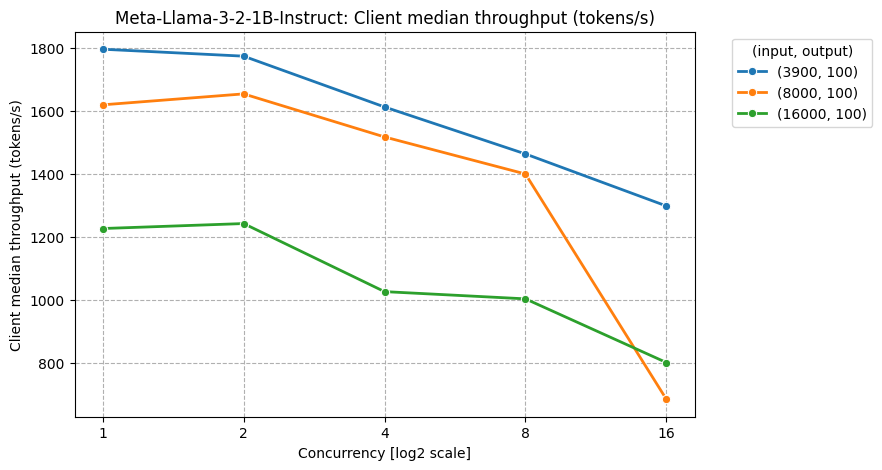

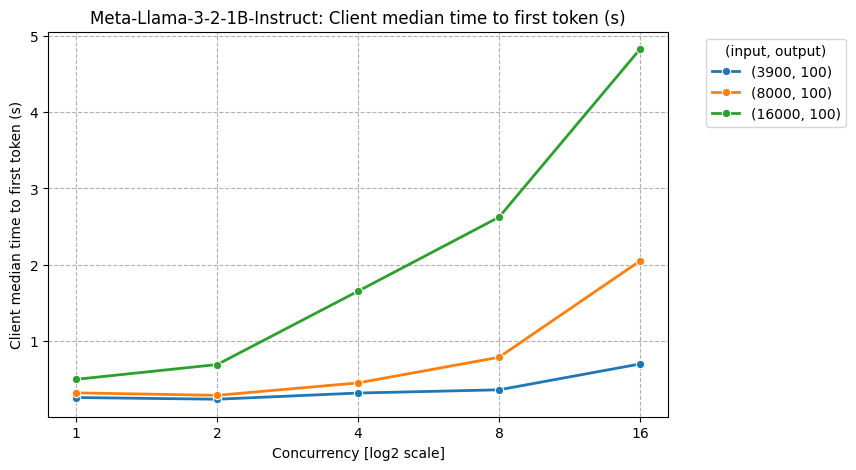

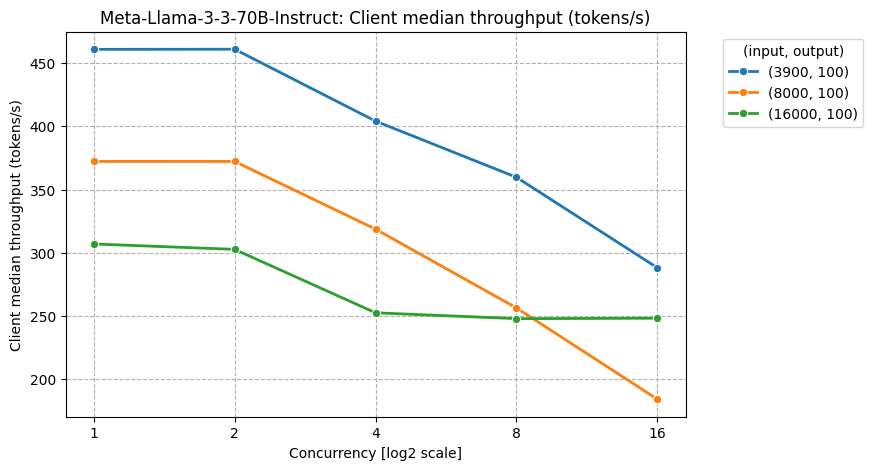

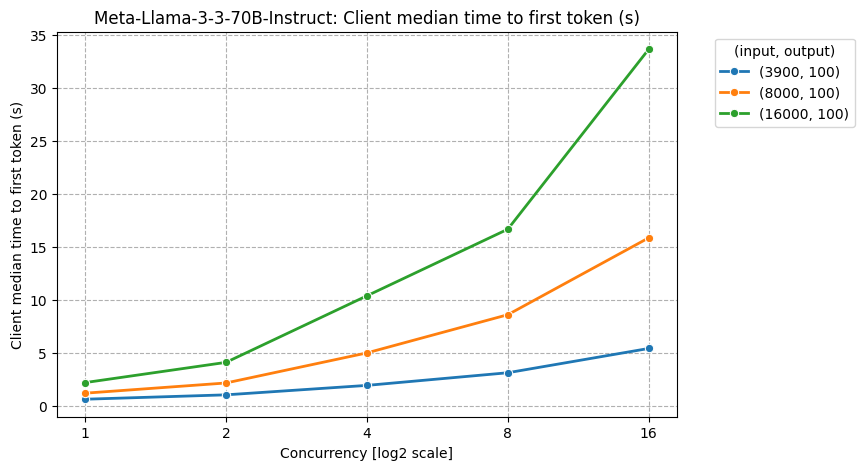

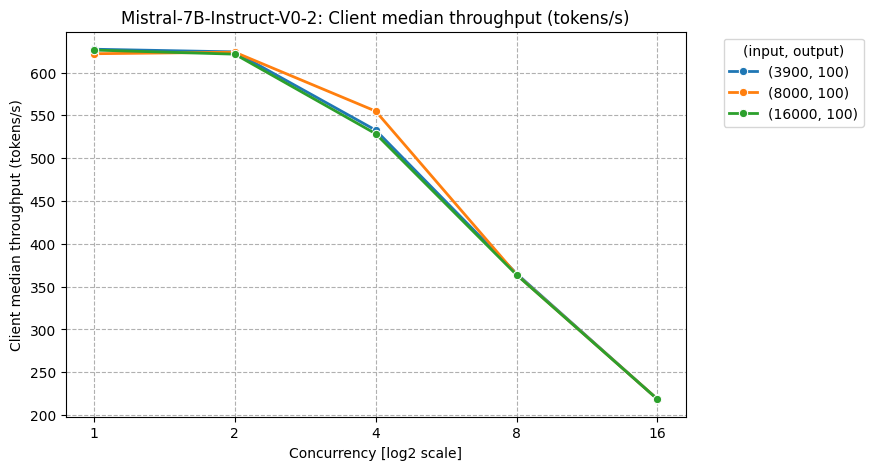

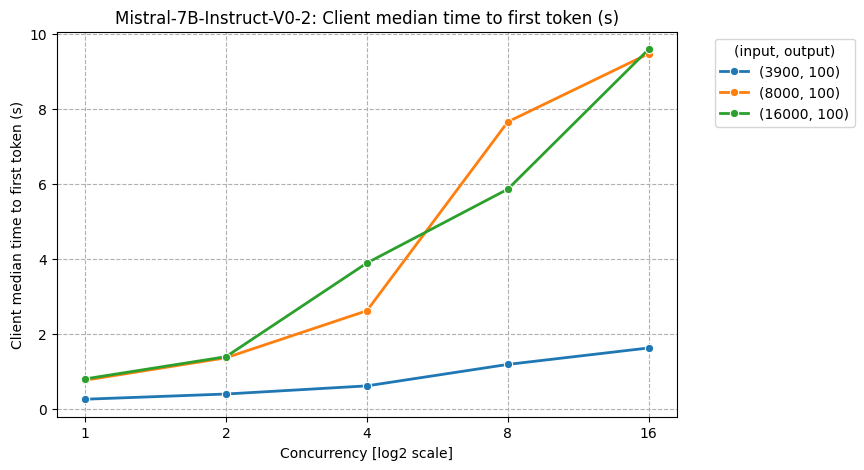

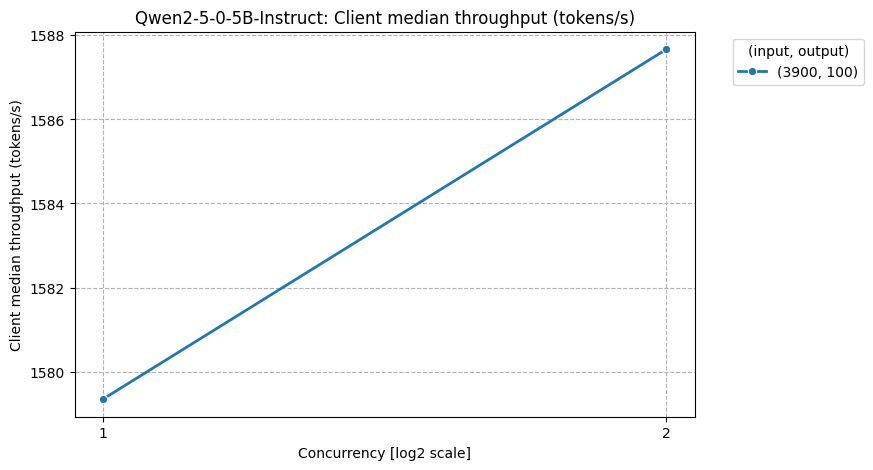

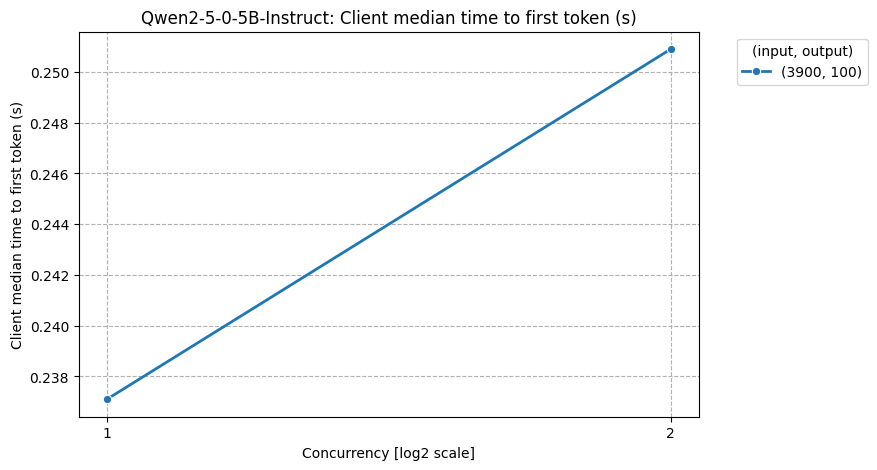

In [24]:
%matplotlib inline
metrics_to_plot = {
    'Client median throughput (tokens/s)': 'server_output_token_per_s_p50',    
    'Client median time to first token (s)': 'client_ttft_s_p50'
}

for model in sorted(df_current["model"].unique()):
    for metric in metrics_to_plot:
        plot_benchmarking_data(df_current[df_current["model"] == model], 
                                metric, 
                                metrics_to_plot[metric], model)

## 7. Compare with alternative benchmarking results

In [23]:
current_name = "DSO Endpoint"
alt_name = "Cloud Master"
df_current["source"] = current_name

#### Read results from alternative source

In [24]:
alt_type = "master" # "run" or "master"

if alt_type == "run":
    alt_run_name = "salesforce_xlam2_70b_short_studio_20250523_1"
    current_file_path = os.path.join(config["consolidated_results_dir"], f'{alt_run_name}.xlsx')
    df_alt = pd.read_excel(current_file_path, sheet_name='Sheet1')
    df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
    df_alt["source"] = alt_name
    df_alt.head()
if alt_type == "master":
    df_alt = pd.read_excel('~/Downloads/Master_Benchmarking_Sheet.xlsx', sheet_name='Sheet1',  header=0, index_col=[0, 1, 2, 3]).reset_index()
    df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
    df_alt["source"] = alt_name
    df_alt.head()

#### Combine dataframes

In [25]:
df_current.shape, df_alt.shape

((15, 45), (36, 38))

In [26]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

37

In [27]:
first_columns = ['source','model','num_input_tokens','num_output_tokens','num_concurrent_requests']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results["server_rated_throughput"] = results["server_output_token_per_s_p50"] * results["representative_batch_size"]
results["total_latency"] =  results["num_completed_requests"]*60/results["num_completed_requests_per_min"]
results.head()

,source,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,server_rated_throughput,total_latency
0,DSO Endpoint,Meta-Llama-3-1-405B-Instruct,3900,100,1,1.3604,1.3633,6.2525,2.0798,2.0838,6.9810,116.9128,137.2305,137.6224,NaN,NaN,NaN,3934,100,1.5172,1.6633,6.9467,2.2309,2.3638,7.7780,117.6706,140.7287,164.5738,40.4042,64,64,24.2425,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,137.2305,158.399505
1,DSO Endpoint,Meta-Llama-3-1-405B-Instruct,3900,100,2,1.3603,1.3639,1.3745,2.0793,2.0846,2.0950,136.3510,137.1973,137.5380,NaN,NaN,NaN,3934,100,1.5340,3.5605,3.6727,2.2498,4.2708,4.4546,111.0659,140.2420,164.4124,46.7577,64,64,28.0546,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,137.1973,136.875949
2,DSO Endpoint,Meta-Llama-3-1-405B-Instruct,3900,100,4,1.3607,5.0450,10.0106,2.0803,5.8309,10.8023,104.7934,125.4357,137.6374,NaN,NaN,NaN,3934,100,1.5233,7.2449,12.4267,2.2328,8.0208,13.2480,121.5920,128.6267,159.0834,47.8829,64,64,28.7297,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4,501.7428,133.659593
3,DSO Endpoint,Meta-Llama-3-1-405B-Instruct,3900,100,8,1.3641,5.0436,5.0537,2.0842,5.8302,5.8433,125.0879,125.3935,137.4071,NaN,NaN,NaN,3934,100,1.5179,10.9996,13.2371,2.2291,11.7742,14.0130,126.5725,128.9489,146.4660,66.3200,64,64,39.7920,0,{},"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4,501.5740,96.501809
4,DSO Endpoint,Meta-Llama-3-1-405B-Instruct,3900,100,16,1.3653,5.0439,5.0488,2.0894,5.8308,5.8358,124.8277,125.3939,136.7181,NaN,NaN,NaN,3934,100,1.5353,22.7748,25.0270,2.2517,23.5516,25.8090,127.2134,128.2702,150.4165,66.3120,64,64,39.7872,0,{},"[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4,501.5756,96.513452


### Plot benchmarking charts among runs

You may change the pallette color based on the color that better identifies each run. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

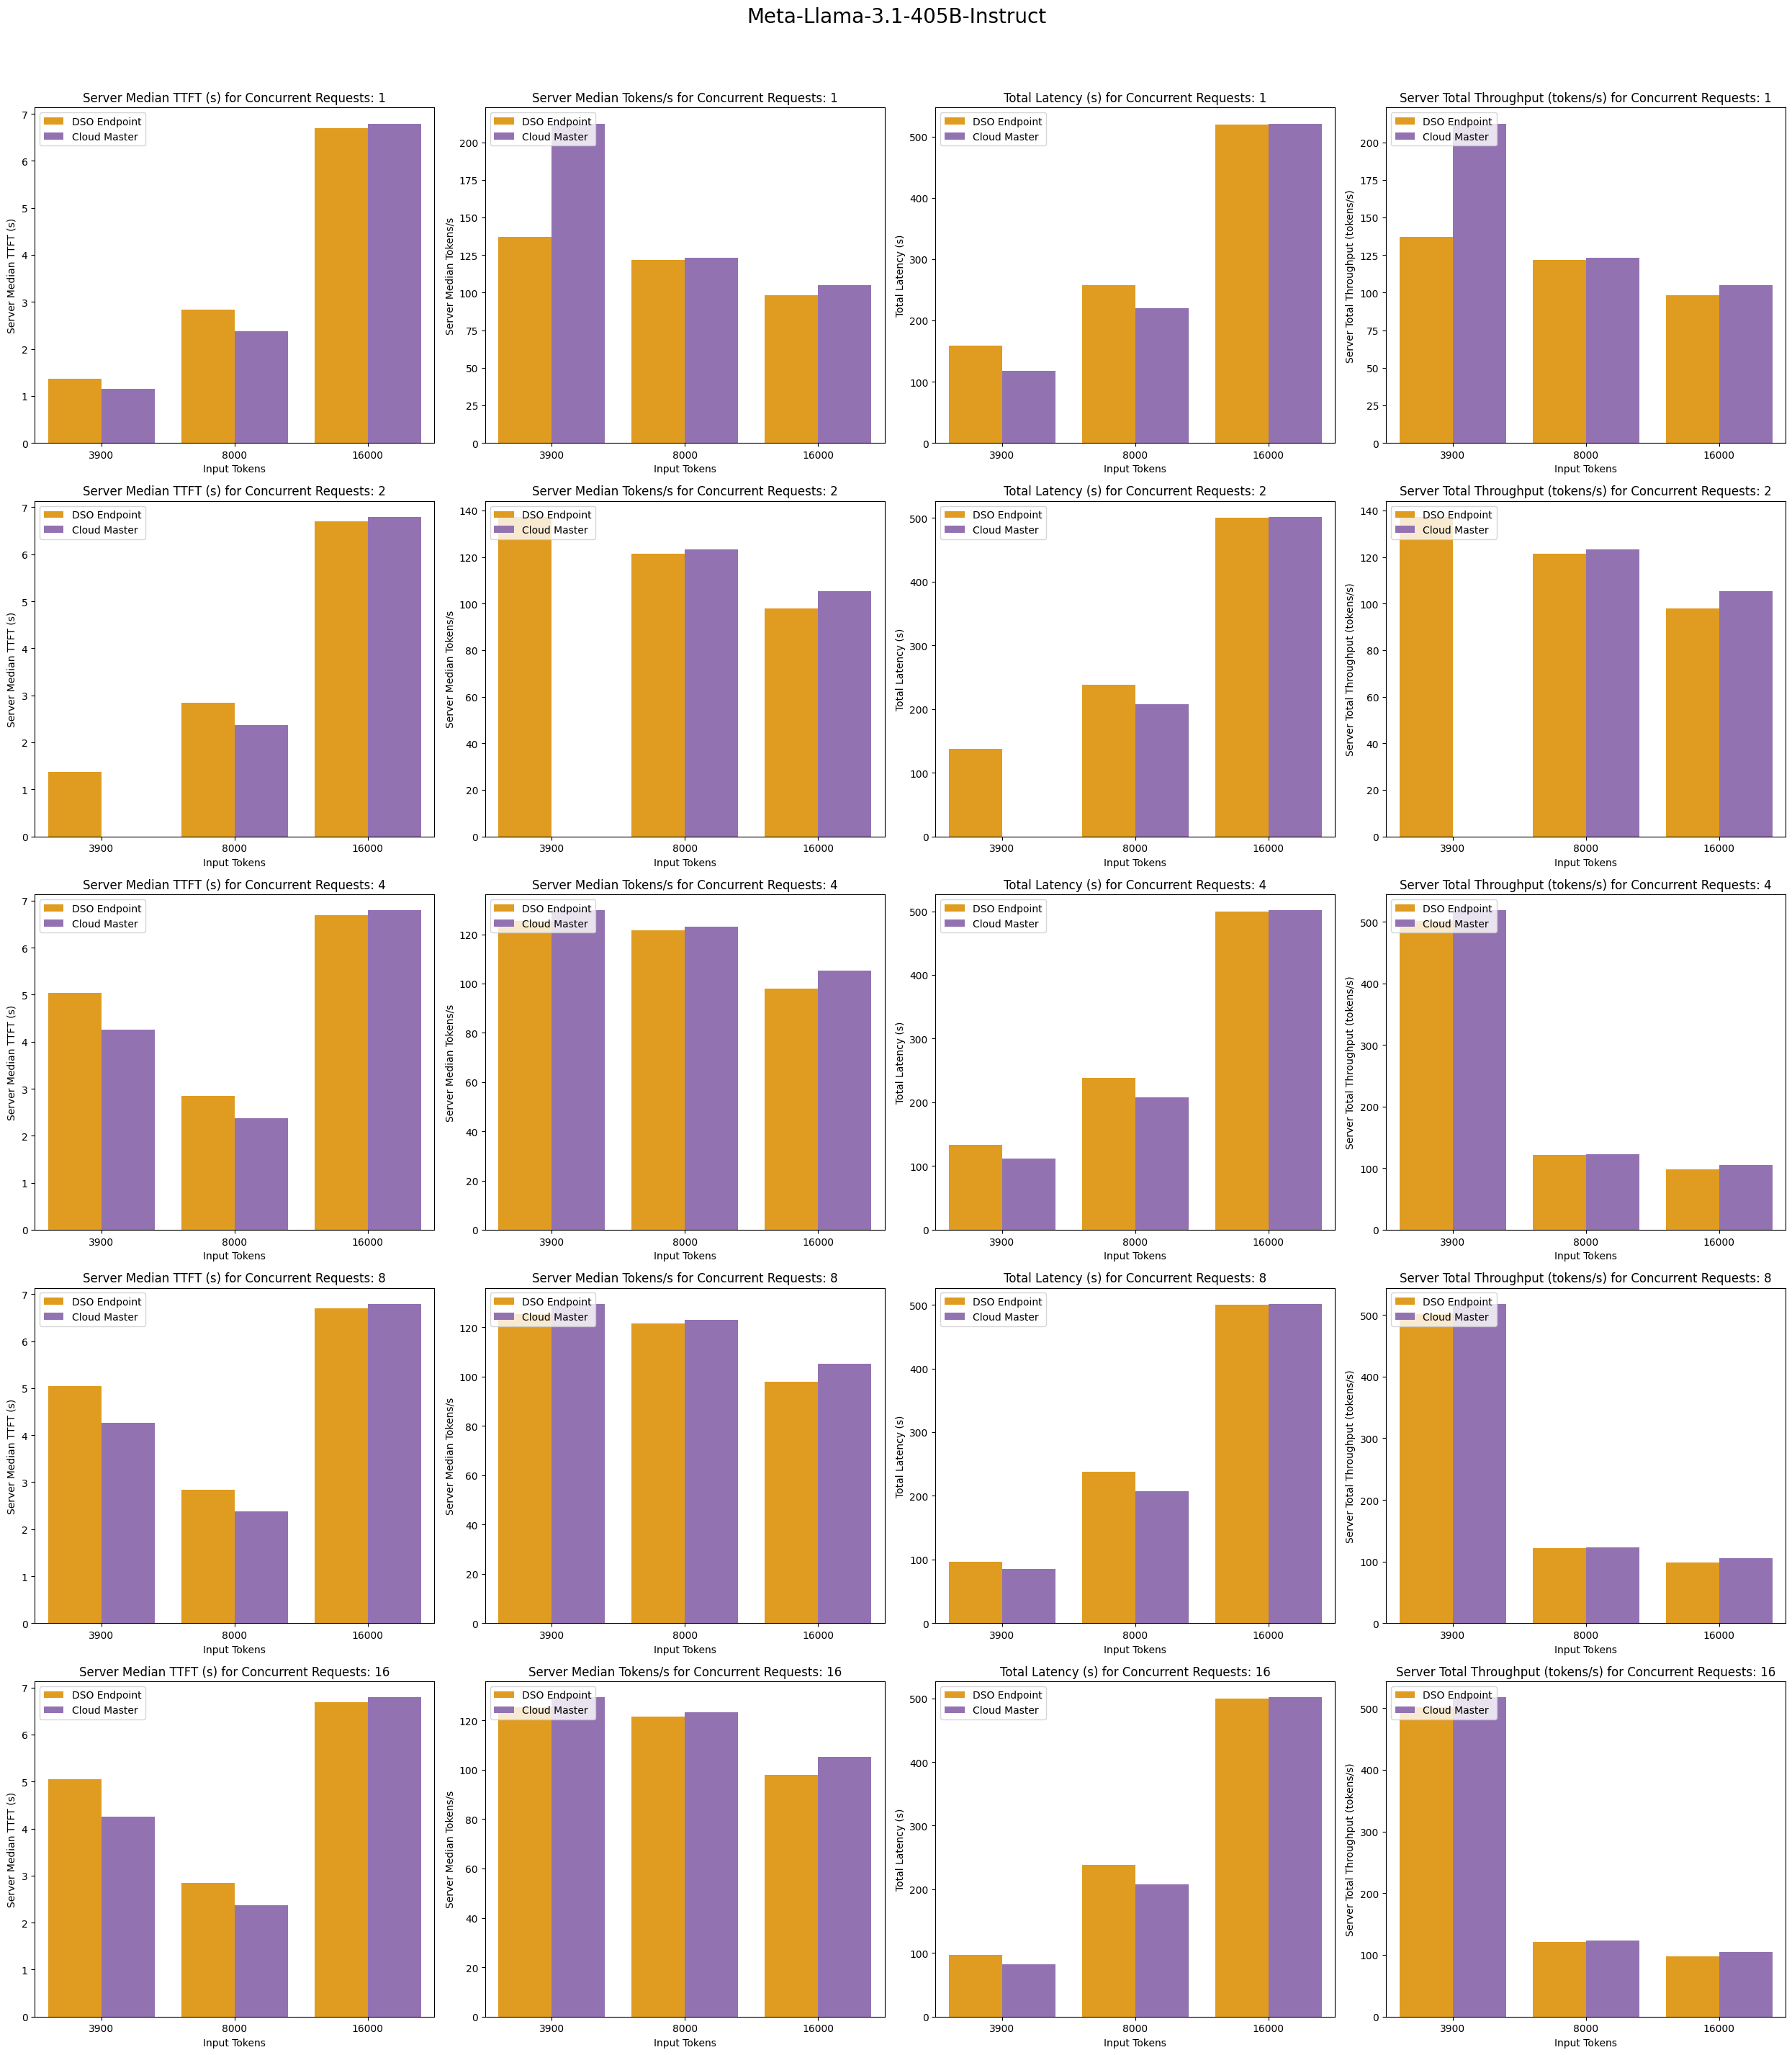

In [29]:
%matplotlib inline

# Pallette for the run, change colors and run names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Server Median TTFT (s)": "server_ttft_s_p50",
    "Server Median Tokens/s": "server_output_token_per_s_p50",
    "Total Latency (s)": "total_latency",
    "Server Total Throughput (tokens/s)": "server_rated_throughput",
}

# Get unique concurrent values
concurrent_values = sorted(concurrent_requests)
num_input_tokens = input_tokens

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), len(fields), figsize=(25, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]   
        subset = subset[subset['num_input_tokens'].isin(num_input_tokens)]     
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='num_input_tokens', y=fields[field], hue='source', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [ ]:
import os
import openai

client = openai.OpenAI(
    api_key=endpoint_key,
    base_url=endpoint_url,
)

for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name

    # Send messages to endpoint
    response = client.chat.completions.create(
        model=model_name,
        messages=test_messages,
        temperature =  0.01,
        top_p = 0.1
    )
    print(f"-------- {model_name} --------")
    print(response.choices[0].message.content)
    print()